In [1]:
import copy
import multiprocessing

import pycuda
import pycuda.autoinit
from win32ctypes.pywin32.pywintypes import datetime

from set_notebook_path import check_path

check_path()

'C:\\Users\\dkb73\\Desktop\\Fullstack\\terean-full-stack'

In [2]:
# General useful imports
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import disba
import multiprocessing
import copy
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from backend.utils.sgy_utils import load_segy, preprocess_streams, trapezoidal_filter_stream, load_segy_segyio
from backend.oneds_dev import generate_combined_grid, calc_grid_stats, plot_from_grid, quick_plot, multi_vspect_stream

from backend.utils.utils import feet_to_meters, spectral_cmap, get_prepend_time, new_spectral_cmap
from backend.utils.utils_1ds_cpu import split_spectra, smooth_pf, pf_ratio, flatten_spectra

from typing import Iterable
import math


%load_ext autoreload
%autoreload 2

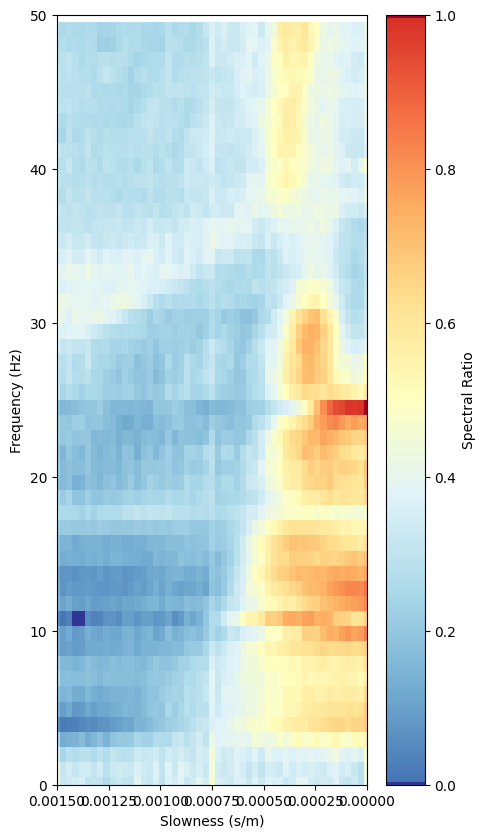

<Figure size 640x480 with 0 Axes>

In [6]:
# sgy_dir = "C:/Users/dkb73/Desktop/Fullstack/terean-full-stack/test_data/MindenHanger-26.25feet-12channel-806fps/SGY"
# spacing_ft = 26.25
# max_slow = 0.013

sgy_dir = "C:/Users/dkb73/Desktop/Fullstack/terean-full-stack/test_data/ECS-Louisville/LINE 1/AllSgy"
spacing_ft = 26.25
max_slow = 0.0015


max_freq = 50
sgy_files = [os.path.join(sgy_dir, x) for x in os.listdir(sgy_dir) if x.endswith(".sgy")]
spacing_meters = feet_to_meters(spacing_ft)


streams = load_segy_segyio(sgy_files)
preprocess_streams(streams)
_, _, _ = quick_plot(
    st=streams,
    mf=max_freq,
    ms=max_slow,
    nf=50,
    num_points=50,
    spacing=spacing_meters,
    method="cuda",
    timing=False,
)
# streams = load_segy_segyio(sgy_files)
# preprocess_streams(streams)
# for i in range(len(streams)):
#     print(f"Processing sgy {sgy_files[i]}")
#     _, _, _ = quick_plot(
#         st=[streams[i], ],
#         mf=max_freq,
#         ms=max_slow,
#         nf=50,
#         num_points=50,
#         spacing=spacing_meters,
#         method="serial",
#         timing=False,
#         title=f"idx={i}"
#     )

In [6]:
packaged_data = multi_vspect_stream(
    streams=sgy_files,
    geophone_distance=spacing_meters,
    f_min=0.0,
    f_max=max_freq,
    f_points=50,
    p_points=30,
    p_max=max_slow,
    tau_points=None,
    low_down_mult=0.8,
    high_down_mult=1.2,
    extend_data=False,
    num_traces=None,
    trace_indices=None,
    cuda_kernel_path="C:/Users/dkb73/Desktop/Fullstack/terean-full-stack/backend/cuda/single_trace.cuda",
    timing=False,
    global_time=None,
    method="cuda",
    reduction_factor=1.0,
    reduce_nyquist_to_f_max=True,
    num_proc=6,
)
p_values = packaged_data["p_values"]
freq_values = packaged_data["freq_values"]
grids = packaged_data["grids"]

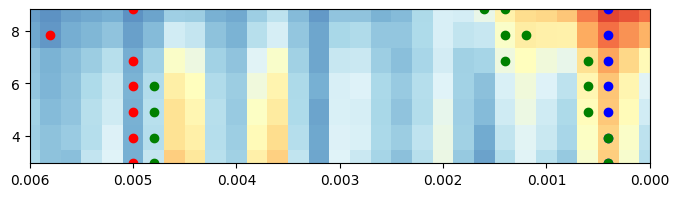

<Figure size 640x480 with 0 Axes>

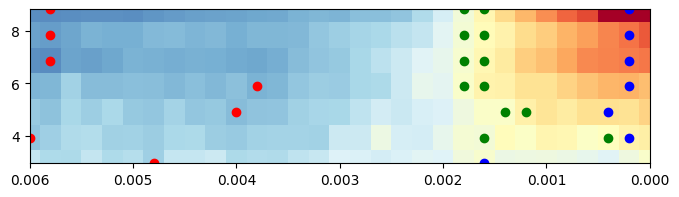

0.0

<Figure size 640x480 with 0 Axes>

In [7]:
from backend.oneds_dev import get_quality_bands, plot_band_intensities, calculate_quality_on_band

record_idx = 11

all_grids = [x['combined_grid'] for x in grids]
all_ratio_grids = [pf_ratio(x) for x in all_grids]
all_normalized_grids = [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in all_ratio_grids]
single_record_bands = get_quality_bands(
    pf_data=grids[record_idx]['combined_grid'],
    freq_data=freq_values,
)
pf_ratio_bands = get_quality_bands(
    pf_data=pf_ratio(grids[record_idx]['combined_grid']),
    freq_data=freq_values,
)
individual_normalized_bands = get_quality_bands(
    pf_data=all_normalized_grids[record_idx],
    freq_data=freq_values,
)
best_grid_idxs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
best_grids = [all_grids[x] for x in best_grid_idxs]
flattened_grid = flatten_spectra(best_grids)
spectral_grid = pf_ratio(flattened_grid)
normalized_grid = (spectral_grid - np.min(spectral_grid)) / (np.max(spectral_grid) - np.min(spectral_grid))
flattened_bands = get_quality_bands(
    pf_data=flattened_grid,
    freq_data=freq_values,
)
spectral_bands = get_quality_bands(
    pf_data=spectral_grid,
    freq_data=freq_values,
)
normalized_bands = get_quality_bands(
    pf_data=normalized_grid,
    freq_data=freq_values,
)
band_index = 0
# plot_band_intensities(slow_data=p_values, band_dict=single_record_bands[band_index])
# plot_band_intensities(slow_data=p_values, band_dict=pf_ratio_bands[band_index])
# plot_band_intensities(slow_data=p_values, band_dict=flattened_bands[band_index])
plot_band_intensities(slow_data=p_values, band_dict=normalized_bands[band_index])
calculate_quality_on_band(band_dict=normalized_bands[band_index], slow_values=p_values)
plot_band_intensities(slow_data=p_values, band_dict=individual_normalized_bands[band_index])
calculate_quality_on_band(band_dict=individual_normalized_bands[band_index], slow_values=p_values)

In [ ]:


def rebin_fft(
        fft_vals,
        fft_freqs,
        min_freq,
        max_freq,
        num_bins,
        nyquist,
):
    # Partially stolen from https://stackoverflow.com/questions/49844496/averaging-data-in-bins
    pos_mask = np.where(fft_freqs >= 0)
    neg_mask = np.where(fft_freqs < 0)
    neg_freqs = fft_freqs[neg_mask]
    pos_freqs = fft_freqs[pos_mask]
    neg_ffts = fft_vals[neg_mask]
    pos_ffts = fft_vals[pos_mask]
    sorted_ffts = np.concatenate((neg_ffts, pos_ffts))
    sorted_freqs = np.concatenate((neg_freqs, pos_freqs))

    bin_size = nyquist / num_bins
    half_bin_size = bin_size / 2
    bin_border = np.concatenate([
        np.linspace(nyquist, -1 * half_bin_size, num_bins + 1, endpoint=True),
        np.linspace(half_bin_size, nyquist, num_bins + 1, endpoint=True)
    ])
    new_bin_centers = (bin_border[1:] + bin_border[:-1]) / 2

    # Finds where sorted freqs change from one bin to the next
    bin_border_idxs = np.searchsorted(sorted_freqs, bin_border)

    # Number of elements in each new bin
    bin_lens = np.diff(bin_border_idxs)

    # Generate new bins
    # Sum
    new_bin_vals_sum = np.where(bin_lens == 0, np.nan, np.add.reduceat(sorted_ffts, bin_border_idxs[:-1]))
    # Average
    new_bin_vals_avg = np.where(bin_lens == 0, np.nan, np.add.reduceat(sorted_ffts, bin_border_idxs[:-1]) / bin_lens)

    return "Bleh"

In [ ]:

# sgy_dir = "C://Users//dkb73//Downloads//remi16//Save"
# spacing_ft = 10
# max_slow = 0.01

# sgy_dir = "C:/Users/dkb73/Downloads/MindenHanger-26.25feet-12channel-806fps-20250321T163906Z-001/MindenHanger-26.25feet-12channel-806fps/SGY"
# spacing_ft = 26.25
# max_slow = 0.009812148885416339

# sgy_dir = "C:/Users/dkb73/Downloads/Earth Eng Oaks Park/Line 1 - 10ft - E-W/Line1-10ft-data"
# spacing_ft = 10
# max_slow = 0.009069432227353279

# sgy_dir = "C:/Users/dkb73/Downloads/Earth Eng Oaks Park/Line 2 - 15ft S-N/sgy"
# spacing_ft = 15
# max_slow = 0.009026538262243453

# sgy_dir = "C:/Users/dkb73/Downloads/Earth Eng Oaks Park/Line 3 - 30ft S-N/sgy"
# spacing_ft = 30
# max_slow = 0.007580444243584139

# sgy_dir = "C:/Users/dkb73/Downloads/Earth Eng Oaks Park/Line 4 - 15ft S-N/sgy"
# spacing_ft = 15
# max_slow = 0.008928675856843527

# sgy_dir = "C:/Users/dkb73/Downloads/A6_Pipeline_Otay_Mesa_Line_3_5ft_spacing_JohnLouie_09042024/Save/"
# spacing_ft = 5
# max_slow = 0.009874870284656138

# sgy_dir = "C:/Users/dkb73/Downloads/ECX 12-20250320T161413Z-001/ECX 12/Line 4"
# spacing_ft = 10
# max_slow = 0.011526799908195978

# sgy_dir = "C:/Users/dkb73/Downloads/ECX 12-20250320T161413Z-001/ECX 12/Line 3"
# spacing_ft = 10
# max_slow = 0.008703289498599389

In [9]:
# Check text headers
import segyio

file_path = "C:/iSeis_Data/VScope/Project53/Save/0001.sgy"
f = segyio.open(file_path, ignore_geometry=True)

In [13]:
print(f.text)

bytearray(b'C 1 CLIENT                        COMPANY                       CREW
 NO         C 2 LINE            AREA                        MAP ID              
            C 3 REEL NO           DAY START OF REEL     YEAR         OBSERVER   
            C 4 INSTRUMENT: MFG            MODEL            SERIAL NO           
            C 5 DATA TRACES/RECORD        AUXULIARY TRACES/RECORD         CDP FO
LD          C 6 SAMPLE INTERVAL         SAMPLES/TRACE       BITS/IN      BYTES/S
AMPLE       C 7 RECORDING FORMAT        FORMAT THIS REEL        MESUREMENT SYSTE
M           C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORR
ELATED      C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER       
            C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND     -     HZ  SLOPE   
 -    DB/OCTC11 SOURCE: TYPE            NUMBER /POINT       POINT INTERVAL      
            C12 PATTERN:                               LENGTH        WIDTH      
            C13 SWEEP: START

In [19]:
f.ext_headers

0